1. Image
2. Grayscale
3. Crop Face
4. Data Preprocess: normalize (0-1) and resize image (100x100)
5. Flatten
6. Eigen Face
7. ML Model 

In [146]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [5]:
femalepath = glob('data/raw/female/*jpg')
malepath = glob('data/raw/male/*jpg')
print('Total Female pics:\t', len(femalepath))
print('Total Male pics:\t', len(malepath))

Total Female pics:	 7000
Total Male pics:	 7000


Image shape: (489, 490, 3)


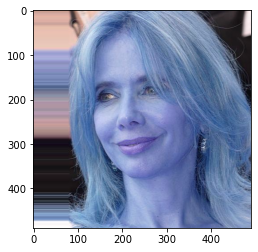

In [6]:
# Let's consider one image
path = femalepath[0]
img = cv2.imread(path) #cv2 reads in BGR (not RGB)
print('Image shape:', img.shape)
plt.imshow(img)
plt.show()

Image shape: (489, 490)


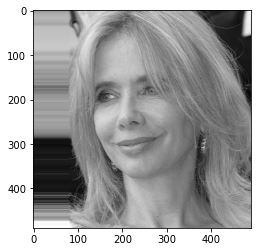

In [7]:
# Convert image into grayscale
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print('Image shape:', img_gray.shape)
plt.imshow(img_gray, cmap='gray')
plt.show()

In [8]:
# Load haar cascade classifier
haar = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')

In [9]:
# Apply classifier to gray image and return face position in X-axis, Y-axis, width and height
faces = haar.detectMultiScale(img_gray, 1.5, 5)
print(faces)

[[ 86  86 273 273]]


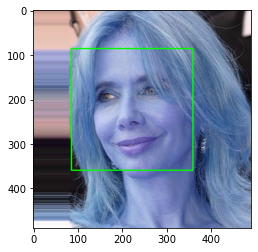

In [10]:
# Draw the rectangle
#0,255,0 is color green and 2 is the width of the line
for x,y,w,h in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
plt.imshow(img)

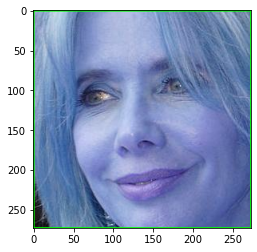

In [11]:
# Crop the image
crop_img = img[y:y+h, x:x+h]
plt.imshow(crop_img)
plt.show()

In [12]:
# Save the image
#cv2.imwrite('TEST-f_01.png', crop_img)

In [13]:
# Apply to all the images
def extract_images(path, gender, i):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(img_gray, 1.5, 5)
    for x,y,w,h in faces:
        roi = img[y:y+h, x:x+w]
        if gender == 'male':
            cv2.imwrite('data/crop/male_crop/{}_{}.png'.format(gender,i), roi)
        else:
            cv2.imwrite('data/crop/female_crop/{}_{}.png'.format(gender,i), roi)

In [14]:
#Testing
#extract_images(femalepath[0], 'female', 1)

In [41]:
#for i, path in enumerate(femalepath):
#    try:
#        extract_images(path,'female', i)
#    except:
#        print('INFO: image not processed - {}'.format(femalepath[i]))

In [142]:
#for i, path in enumerate(malepath):
#    try:
#        extract_images(path,'male', i)
#    except:
#        print('INFO: image not processed - {}'.format(malepath[i]))

# 4 & 5

## Structuring the Data

In [14]:
female = glob('data/crop/female_crop/*.png')
male = glob('data/crop/male_crop/*.png')

In [15]:
path = female+male

In [16]:
# Getting size of image (px)
def getSize(path):
    img = Image.open(path)
    return img.size[0]

In [17]:
# Create DataFrame and apply get size
df = pd.DataFrame(data=path, columns=['path'])
df['size'] = df['path'].apply(getSize)
df

,path,size
0,data/crop/female_crop\female_0.png,273
1,data/crop/female_crop\female_1.png,182
2,data/crop/female_crop\female_100.png,182
3,data/crop/female_crop\female_1003.png,182
4,data/crop/female_crop\female_1008.png,81
...,...,...
6053,data/crop/male_crop\male_989.png,182
6054,data/crop/male_crop\male_99.png,273
6055,data/crop/male_crop\male_991.png,122
6056,data/crop/male_crop\male_995.png,182


### Brief EDA

In [18]:
df.describe()

,size
count,6058.000000
mean,153.879333
std,71.089884
min,24.000000
25%,81.000000
50%,122.000000
75%,182.000000
max,410.000000


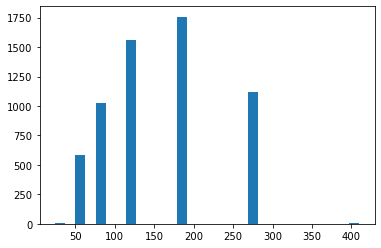

In [19]:
plt.hist(df['size'], bins=30);

**All images will be resized to 100x100 form smaller than 54**

In [20]:
df_new = df[df['size']>60]
df_new

,path,size
0,data/crop/female_crop\female_0.png,273
1,data/crop/female_crop\female_1.png,182
2,data/crop/female_crop\female_100.png,182
3,data/crop/female_crop\female_1003.png,182
4,data/crop/female_crop\female_1008.png,81
...,...,...
6053,data/crop/male_crop\male_989.png,182
6054,data/crop/male_crop\male_99.png,273
6055,data/crop/male_crop\male_991.png,122
6056,data/crop/male_crop\male_995.png,182


In [21]:
df_new['size'].min()

81

### Gender

In [22]:
string = df_new['path'][0]
def gender(string):
    try:
        return string.split('_')[0].split('/')[-1]
    except:
        return None

print('File Path:\t', string)
print('Gender:\t\t', gender(string))

File Path:	 data/crop/female_crop\female_0.png
Gender:		 female


In [23]:
df_new['gender'] = df_new['path'].apply(gender)
df_new

<ipython-input-23-0b7a2eaf093d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['gender'] = df_new['path'].apply(gender)


,path,size,gender
0,data/crop/female_crop\female_0.png,273,female
1,data/crop/female_crop\female_1.png,182,female
2,data/crop/female_crop\female_100.png,182,female
3,data/crop/female_crop\female_1003.png,182,female
4,data/crop/female_crop\female_1008.png,81,female
...,...,...,...
6053,data/crop/male_crop\male_989.png,182,male
6054,data/crop/male_crop\male_99.png,273,male
6055,data/crop/male_crop\male_991.png,122,male
6056,data/crop/male_crop\male_995.png,182,male


female    0.59634
male      0.40366
Name: gender, dtype: float64


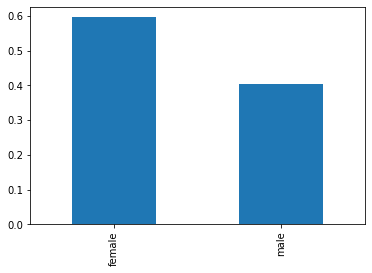

In [24]:
print(df_new['gender'].value_counts(normalize=True))
df_new['gender'].value_counts(normalize=True).plot(kind='bar')
plt.show()

1. 60 % Female and 40% are Male
2. All the images size is greater than or equal to 81

Conclusion : resizing all the image in df_new to 100 x 100 array

### Grayscale, Resize, Flatten Image

In [25]:
def resize_img(path_to_resize):
    try:
        # step1: read image
        img = cv2.imread(path_to_resize)
        # step2: convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # step3: resize into 100x100 array
        size = gray.shape[0]
        if size>=100: #shrink
            gray_re = cv2.resize(gray, (100,100), cv2.INTER_AREA)
        else: #enlarge
            gray_re = cv2.resize(gray, (100,100), cv2.INTER_CUBIC)
        # step4: flatten image (1x10.000)
        return gray_re.flatten()
    except:
        return None

In [26]:
# structuring function
df_new['structure_data'] = df_new['path'].apply(resize_img)
df_new

<ipython-input-26-f79f99db5bb0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['structure_data'] = df_new['path'].apply(resize_img)


,path,size,gender,structure_data
0,data/crop/female_crop\female_0.png,273,female,"[188, 180, 184, 188, 173, 179, 192, 178, 216, ..."
1,data/crop/female_crop\female_1.png,182,female,"[32, 24, 32, 27, 29, 29, 29, 32, 36, 30, 46, 8..."
2,data/crop/female_crop\female_100.png,182,female,"[22, 30, 39, 36, 30, 61, 11, 17, 10, 19, 13, 1..."
3,data/crop/female_crop\female_1003.png,182,female,"[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 3..."
4,data/crop/female_crop\female_1008.png,81,female,"[86, 86, 71, 54, 45, 49, 33, 20, 18, 23, 27, 2..."
...,...,...,...,...
6053,data/crop/male_crop\male_989.png,182,male,"[31, 31, 31, 31, 31, 31, 31, 31, 30, 29, 29, 3..."
6054,data/crop/male_crop\male_99.png,273,male,"[88, 41, 33, 18, 15, 14, 13, 29, 25, 74, 114, ..."
6055,data/crop/male_crop\male_991.png,122,male,"[25, 25, 26, 25, 26, 31, 35, 46, 60, 114, 195,..."
6056,data/crop/male_crop\male_995.png,182,male,"[21, 27, 31, 24, 19, 24, 21, 19, 31, 36, 15, 2..."


In [27]:
# copy and expand their columns
df1 = df_new['structure_data'].apply(pd.Series)
df1 = pd.concat((df_new['gender'], df1), axis=1)
df1

,gender,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,female,188,180,184,188,173,179,192,178,216,...,109,111,115,116,122,116,119,120,117,111
1,female,32,24,32,27,29,29,29,32,36,...,58,47,27,33,22,28,22,36,62,17
2,female,22,30,39,36,30,61,11,17,10,...,156,171,177,186,176,185,186,190,177,177
3,female,35,35,35,35,35,35,35,35,35,...,75,82,90,92,86,70,89,84,84,74
4,female,86,86,71,54,45,49,33,20,18,...,35,34,32,32,30,32,34,34,33,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,male,31,31,31,31,31,31,31,31,30,...,72,72,39,21,39,32,28,49,87,28
6054,male,88,41,33,18,15,14,13,29,25,...,47,49,117,12,114,87,17,131,21,106
6055,male,25,25,26,25,26,31,35,46,60,...,45,46,44,41,37,34,31,30,31,34
6056,male,21,27,31,24,19,24,21,19,31,...,22,14,11,16,16,19,23,20,22,25


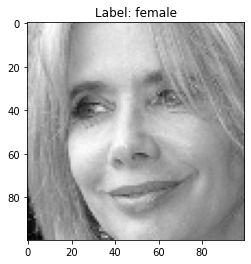

In [28]:
# Plot 1 example
plt.imshow(df1.loc[0][1:].values.reshape(100,100).astype('int'), cmap='gray')
plt.title("Label: "+ df1.loc[0]['gender'])
plt.show()

# Eigen Images

In [150]:
X = np.array(df1.iloc[:,1:])
y = np.array(df1.iloc[:,0])
X.shape, y.shape

((5465, 10000), (5465,))

# Principal Component Analysis (PCA)

In [30]:
X1 = X - X.mean(axis=0)

In [31]:
pca = PCA(n_components=None, whiten=True, svd_solver='auto')

In [32]:
%%time
x_pca = pca.fit_transform(X1)

Wall time: 2min 19s


In [57]:
x_pca.shape

(5465, 5465)

Text(0, 0.5, 'Explained variance Ratio Acum')

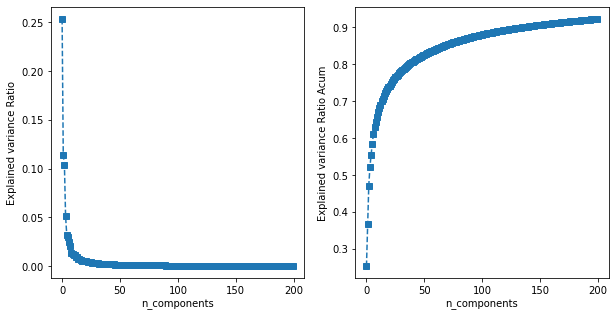

In [58]:
eigen_values_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(eigen_values_ratio[:200],'s--')
plt.xlabel('n_components')
plt.ylabel('Explained variance Ratio')

plt.subplot(1,2,2)
plt.plot(np.cumsum(eigen_values_ratio[:200]),'s--')
plt.xlabel('n_components')
plt.ylabel('Explained variance Ratio Cumulative')

Conclusion: from elbow method, optimal number of component is in the range of 25 - 30.
Since if I consider component between 25-30 the explained variance is around 75% so, in order to get min 80% of variance I am considering 50 components

In [61]:
pca_50 = PCA(n_components=50, whiten=True, svd_solver='auto')
x_pca_50 = pca_50.fit_transform(X1)
x_pca_50.shape

(5465, 50)

In [62]:
# Saving PCA
import pickle
pickle.dump(pca_50, open('model/pca_50.pickle', 'wb'))

In [63]:
# Consider 50 component and inverse transform
x_inv_trans  = pca_50.inverse_transform(x_pca_50)
x_inv_trans.shape

(5465, 10000)

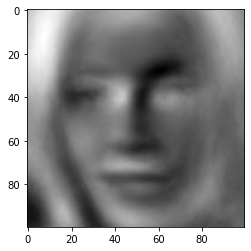

In [65]:
# Consider 1st row
eig_img = x_inv_trans[0,:]
eig_img = eig_img.reshape((100,100))
plt.imshow(eig_img, cmap='gray');

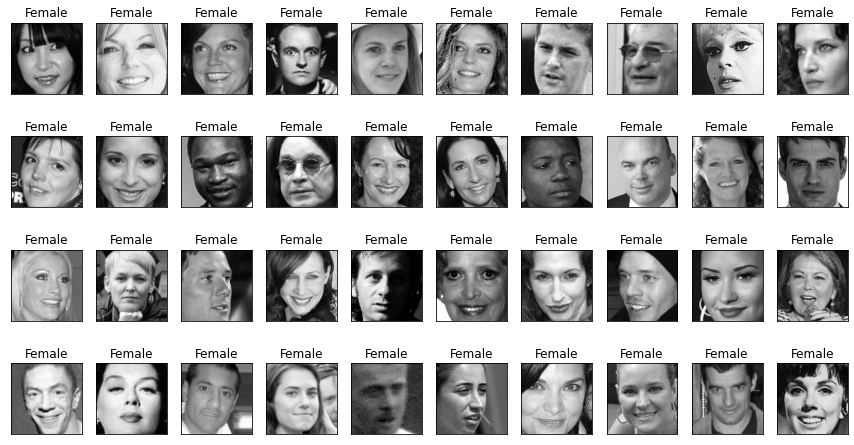

====================Eigen Images====================


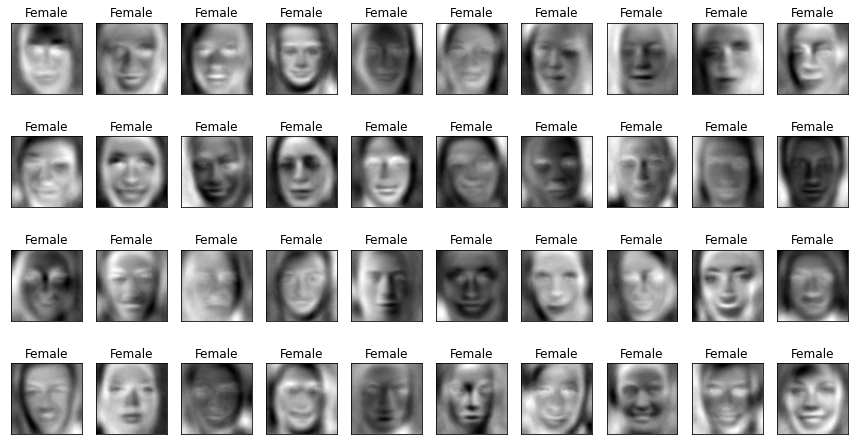

In [66]:
def label(y):
    if y==0:
        return 'Male'
    else:
        return 'Female'
    
# Creating a subset to plot as a demo
np.random.randint(1001)
pics = np.random.randint(0, 5451, 40)

# Plotting imgs
plt.figure(figsize=(15,8))
for i, pic in enumerate(pics):
    plt.subplot(4,10, i+1)
    img = X[pic:pic+1].reshape(100,100)
    plt.imshow(img, cmap='gray')
    plt.title('{}'.format(label(y[pic])))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)

# Plotting Eigen imgs
plt.figure(figsize=(15,8))
for i, pic in enumerate(pics):
    plt.subplot(4,10, i+1)
    img = x_inv_trans[pic:pic+1].reshape(100,100)
    plt.imshow(img, cmap='gray')
    plt.title('{}'.format(label(y[pic])))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [67]:
# Saving
np.savez('data/data_pca_50_y_mean.pickle', x_pca_50, y, X.mean(axis=0))

# Chck here value of Y 0,1 or male,female

In [151]:
y

array(['female', 'female', 'female', ..., 'male', 'male', 'male'],
      dtype=object)

In [154]:
X = x_pca_50
y = np.array([0 if i=='male' else 1 for i in y])
mean = X.mean(axis=0)

# Train Test Split

In [155]:
# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4372, 50), (1093, 50), (4372,), (1093,))

# Model Training

In [156]:
# SVC: Support Vector Classifier
model = SVC(C=10, gamma=0.01, kernel='rbf', probability=True)
model.fit(x_train, y_train)

SVC(C=10, gamma=0.01, probability=True)

In [157]:
model.score(x_train, y_train)

0.9634034766697164

In [158]:
model.score(x_test, y_test)

0.7904849039341263

In [159]:
# Predictions
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)

In [160]:
print(y_pred)
print(y_prob)

[1 1 0 ... 0 1 0]
[[0.27841336 0.72158664]
 [0.23191285 0.76808715]
 [0.88229377 0.11770623]
 ...
 [0.70188986 0.29811014]
 [0.19351105 0.80648895]
 [0.93454896 0.06545104]]


# Model Evaluation
- Confusion Matrix
- Classification Report
- Kappa Score
- ROC and AUC (probability)

In [161]:
cm = confusion_matrix(y_test, y_pred) #, labels=['male','female'])
# Adding cum col/row
cm = np.concatenate((cm,cm.sum(axis=1).reshape(-1,1)), axis=1)
cm = np.concatenate((cm,cm.sum(axis=0).reshape(1,-1)), axis=0)
cm

array([[ 318,  123,  441],
       [ 106,  546,  652],
       [ 424,  669, 1093]], dtype=int64)

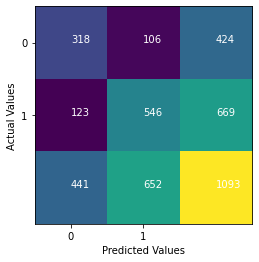

In [162]:
plt.imshow(cm) # YlGnBu
for i in range(3):
    for j in range(3):
        plt.text(i, j, '%d'%cm[i,j], color='w')
        
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.xticks([0,1])
plt.yticks([0,1])
plt.show()

In [163]:
cr = classification_report(y_test, y_pred, output_dict=True, target_names=['Male','Female'])
pd.DataFrame(cr).T

,precision,recall,f1-score,support
Male,0.750000,0.721088,0.735260,441.000000
Female,0.816143,0.837423,0.826646,652.000000
accuracy,0.790485,0.790485,0.790485,0.790485
macro avg,0.783072,0.779256,0.780953,1093.000000
weighted avg,0.789456,0.790485,0.789774,1093.000000


In [164]:
# Kappa
metrics.cohen_kappa_score(y_test, y_pred)

0.562017369027975

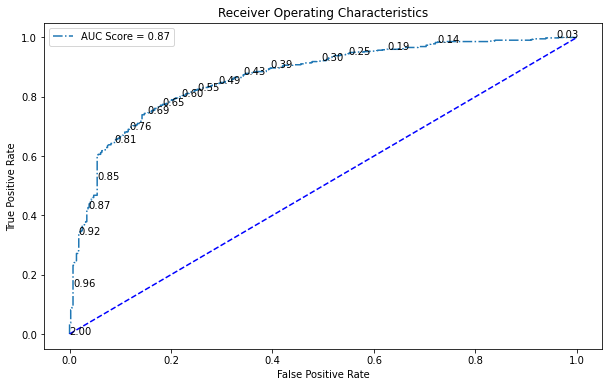

In [165]:
# Plot
# ROC receiver operating characteristic curve
# AUC area under the curve
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob[:,1])
auc_s = metrics.auc(fpr,tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, '-.')
plt.plot([0,1], [0,1], 'b--')
for i in range(0,len(thresh),20):
    plt.text(fpr[i], tpr[i], '%0.2f'%thresh[i])
    
plt.legend(['AUC Score = %0.2f'%auc_s])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.show()

In [166]:
metrics.roc_auc_score(y_test,y_prob[:,1])

0.8682042346590988

# Hyperparameter Tuning

In [ ]:
model_tune = SVC()

In [168]:
param_grid = {'C':[1,10,20,30,50,100],
             'kernel':['rbf','poly'],
             'gamma':[0.1,0.05,0.01,0.001,0.002,0.005],
             'coef0':[0,1],
             }

In [169]:
model_grid = GridSearchCV(model_tune,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=5, #cross validation 
                          verbose=2)

In [170]:
%%time 
#maybe10min
model_grid.fit(X, y) #over full data because of cross validation

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] C=1, coef0=0, gamma=0.1, kernel=rbf .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. C=1, coef0=0, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=0, gamma=0.1, kernel=rbf .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .............. C=1, coef0=0, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=0, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=0, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=1, coef0=0, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=0, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=0, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=0, gamma=0.1, kernel=rbf, total=   1.2s
[CV] C=1, coef0=0, gamma=0.1, kernel=poly ............................
[CV] ............. C=1, coef0=0, gamma=0.1, kernel=poly, total=   1.0s
[CV] C=1, coef0=0, gamma=0.1, kernel=poly ............................
[CV] ............. C=1, coef0=0, gamma=0.1, kernel=poly, total=   0.9s
[CV] C=1, coef0=0, gamma=0.1, kernel=poly ............................
[CV] ............. C=1, coef0=0, gamma=0.1, kernel=poly, total=   1.0s
[CV] C=1, coef0=0, gamma=0.1, kernel=poly ............................
[CV] .

[CV] ........... C=1, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=1, coef0=1, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=1, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=1, coef0=1, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=1, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=1, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=1, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=1, coef0=1, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=1, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=1, gamma=0.1, kernel=rbf .............................
[CV] .............. C=1, coef0=1, gamma=0.1, kernel=rbf, total=   1.1s
[CV] C=1, coef0=1, gamma=0.1, kernel=poly ............................
[CV] ............. C=1, coef0=1, gamma=0.1, kernel=poly, total=   0.7s
[CV] C=1, coef0=1, gamma=0.1, kernel=poly ............................
[CV] .

[CV] ........... C=1, coef0=1, gamma=0.005, kernel=poly, total=   0.6s
[CV] C=1, coef0=1, gamma=0.005, kernel=poly ..........................
[CV] ........... C=1, coef0=1, gamma=0.005, kernel=poly, total=   0.6s
[CV] C=1, coef0=1, gamma=0.005, kernel=poly ..........................
[CV] ........... C=1, coef0=1, gamma=0.005, kernel=poly, total=   0.6s
[CV] C=10, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=0, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=10, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=0, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=10, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=0, gamma=0.1, kernel=rbf, total=   0.9s
[CV] C=10, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=0, gamma=0.1, kernel=rbf, total=   0.9s
[CV] C=10, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] .

[CV] .......... C=10, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=1, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=1, gamma=0.1, kernel=rbf, total=   0.9s
[CV] C=10, coef0=1, gamma=0.1, kernel=rbf ............................
[CV] ............. C=10, coef0=1, gamma=0.1, kernel=rbf, total=   1.0s
[CV] C=10, coef0=1, gamma=0.1, kernel=rbf ............................
[CV] .

[CV] ........... C=10, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=10, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=10, coef0=1, gamma=0.005, kernel=rbf, total=   0.7s
[CV] C=10, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=1, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=1, gamma=0.005, kernel=poly, total=   0.7s
[CV] C=10, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=1, gamma=0.005, kernel=poly, total=   0.7s
[CV] C=10, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=1, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=10, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=10, coef0=1, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=20, coef0=0, gamma=0.1, kernel=rbf ............................
[CV] .

[CV] ........... C=20, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=20, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=20, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .......... C=20, coef0=0, gamma=0.005, kernel=poly, total=   0.8s
[CV] C=20, coef0=0, gamma=0.005, kernel=poly .........................
[CV] .

[CV] .......... C=20, coef0=1, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=20, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=20, coef0=1, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=20, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .......... C=20, coef0=1, gamma=0.005, kernel=poly, total=   0.9s
[CV] C=20, coef0=1, gamma=0.005, kernel=poly .........................
[CV] .

[CV] .......... C=30, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=0, gamma=0.002, kernel=poly, total=   0.8s
[CV] C=30, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=0, gamma=0.005, kernel=rbf, total=   0.9s
[CV] C=30, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=30, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=30, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=0, gamma=0.005, kernel=rbf, total=   0.8s
[CV] C=30, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] .

[CV] .......... C=30, coef0=1, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=1, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=1, gamma=0.002, kernel=poly, total=   0.8s
[CV] C=30, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=1, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=30, coef0=1, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=30, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=1, gamma=0.005, kernel=rbf, total=   0.9s
[CV] C=30, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] ........... C=30, coef0=1, gamma=0.005, kernel=rbf, total=   0.9s
[CV] C=30, coef0=1, gamma=0.005, kernel=rbf ..........................
[CV] .

[CV] ........... C=50, coef0=0, gamma=0.002, kernel=rbf, total=   0.9s
[CV] C=50, coef0=0, gamma=0.002, kernel=rbf ..........................
[CV] ........... C=50, coef0=0, gamma=0.002, kernel=rbf, total=   0.9s
[CV] C=50, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=50, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=50, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=50, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=0, gamma=0.002, kernel=poly, total=   0.8s
[CV] C=50, coef0=0, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=0, gamma=0.002, kernel=poly, total=   0.8s
[CV] C=50, coef0=0, gamma=0.005, kernel=rbf ..........................
[CV] .

[CV] ........... C=50, coef0=1, gamma=0.002, kernel=rbf, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=rbf ..........................
[CV] ........... C=50, coef0=1, gamma=0.002, kernel=rbf, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=rbf ..........................
[CV] ........... C=50, coef0=1, gamma=0.002, kernel=rbf, total=   0.8s
[CV] C=50, coef0=1, gamma=0.002, kernel=rbf ..........................
[CV] ........... C=50, coef0=1, gamma=0.002, kernel=rbf, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=1, gamma=0.002, kernel=poly, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=1, gamma=0.002, kernel=poly, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .......... C=50, coef0=1, gamma=0.002, kernel=poly, total=   0.9s
[CV] C=50, coef0=1, gamma=0.002, kernel=poly .........................
[CV] .

[CV] ......... C=100, coef0=0, gamma=0.001, kernel=poly, total=   0.8s
[CV] C=100, coef0=0, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=0, gamma=0.002, kernel=rbf, total=   1.1s
[CV] C=100, coef0=0, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=0, gamma=0.002, kernel=rbf, total=   1.1s
[CV] C=100, coef0=0, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=0, gamma=0.002, kernel=rbf, total=   1.1s
[CV] C=100, coef0=0, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=0, gamma=0.002, kernel=rbf, total=   1.0s
[CV] C=100, coef0=0, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=0, gamma=0.002, kernel=rbf, total=   1.1s
[CV] C=100, coef0=0, gamma=0.002, kernel=poly ........................
[CV] ......... C=100, coef0=0, gamma=0.002, kernel=poly, total=   0.7s
[CV] C=100, coef0=0, gamma=0.002, kernel=poly ........................
[CV] .

[CV] ......... C=100, coef0=1, gamma=0.001, kernel=poly, total=   0.9s
[CV] C=100, coef0=1, gamma=0.001, kernel=poly ........................
[CV] ......... C=100, coef0=1, gamma=0.001, kernel=poly, total=   0.9s
[CV] C=100, coef0=1, gamma=0.001, kernel=poly ........................
[CV] ......... C=100, coef0=1, gamma=0.001, kernel=poly, total=   1.0s
[CV] C=100, coef0=1, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=1, gamma=0.002, kernel=rbf, total=   1.0s
[CV] C=100, coef0=1, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=1, gamma=0.002, kernel=rbf, total=   1.1s
[CV] C=100, coef0=1, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=1, gamma=0.002, kernel=rbf, total=   1.0s
[CV] C=100, coef0=1, gamma=0.002, kernel=rbf .........................
[CV] .......... C=100, coef0=1, gamma=0.002, kernel=rbf, total=   1.0s
[CV] C=100, coef0=1, gamma=0.002, kernel=rbf .........................
[CV] .

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 10.1min finished


Wall time: 10min 8s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 20, 30, 50, 100], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [171]:
model_grid.best_params_

{'C': 1, 'coef0': 0, 'gamma': 0.05, 'kernel': 'rbf'}

In [172]:
model_grid.best_score_

0.7826166514181153

In [182]:
# With best parameter buil ML Model
model_best = SVC(C=1, kernel='rbf', gamma=0.05, probability=True)
model_best.fit(x_train, y_train)
model_best.score(x_test, y_test)

0.8005489478499542

In [183]:
y_pred = model_best.predict(x_test)
y_prob = model_best.predict_proba(x_test) # proability

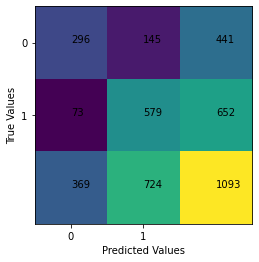

In [184]:
cm = metrics.confusion_matrix(y_test,y_pred)
cm = np.concatenate((cm,cm.sum(axis=0).reshape(1,-1)),axis=0)
cm = np.concatenate((cm,cm.sum(axis=1).reshape(-1,1)),axis=1)
plt.imshow(cm)
for i in range(3):
    for j in range(3):
        plt.text(j,i,'%d'%cm[i,j])
        
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [185]:
# classification report
cr = metrics.classification_report(y_test,y_pred,target_names=['male','female'],output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
male,0.802168,0.671202,0.730864,441.000000
female,0.799724,0.888037,0.841570,652.000000
accuracy,0.800549,0.800549,0.800549,0.800549
macro avg,0.800946,0.779619,0.786217,1093.000000
weighted avg,0.800710,0.800549,0.796903,1093.000000


In [186]:
# kappa
metrics.cohen_kappa_score(y_test,y_pred)

0.5744134373571103

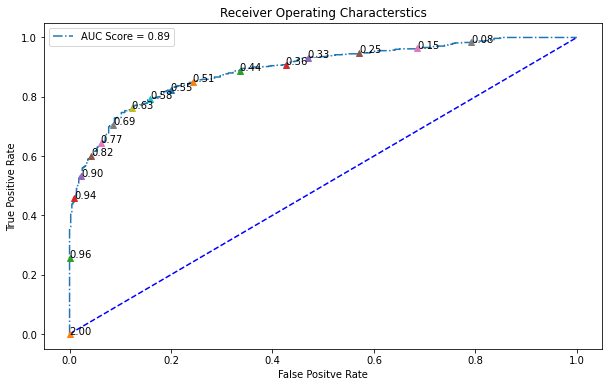

In [187]:
# roc for female
fpr,tpr,thresh = metrics.roc_curve(y_test,y_prob[:,1])
auc_s = metrics.auc(fpr,tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,'-.')
plt.plot([0,1],[0,1],'b--')
for i in range(0,len(thresh),20):
    plt.plot(fpr[i],tpr[i],'^')
    plt.text(fpr[i],tpr[i],"%0.2f"%thresh[i])
    
plt.legend(['AUC Score = %0.2f'%auc_s])

plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characterstics')
plt.show()

In [188]:
# save our machine learning model
import pickle

In [189]:
pickle.dump(model_best,open('model_svm.pickle','wb'))

In [190]:
pickle.dump(mean,open('model/mean_preprocess.pickle','wb'))